# Generate the 3D U-Net model blocks and definitions

In [12]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose,\
  BatchNormalization, Activation, Concatenate


def conv_block(input, num_filters):
  x = Conv3D(num_filters, 3, padding="same")(input)
  # x = BatchNormalization()(x)   #Not in the original network.
  x = Activation("relu")(x)

  x = Conv3D(num_filters, 3, padding="same")(x)
  # x = BatchNormalization()(x)  #Not in the original network.
  x = Activation("relu")(x)

  return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling3D((2, 2, 2))(x)
  return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
  x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 4)
  s2, p2 = encoder_block(p1, 8)
  s3, p3 = encoder_block(p2, 16)
  s4, p4 = encoder_block(p3, 32)

  b1 = conv_block(p4, 64) #Bridge

  d1 = decoder_block(b1, s4, 32)
  d2 = decoder_block(d1, s3, 16)
  d3 = decoder_block(d2, s2, 8)
  d4 = decoder_block(d3, s1, 4)

  if n_classes == 1:  #Binary
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  # Change the activation based on n_classes
  outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(d4)
  print(activation)

  model = Model(inputs, outputs, name="U-Net")
  return model

In [11]:
from keras import backend as K

def dice_coefficient(predictions, targets, smoothing_factor=1e-6):
  predictions = tf.cast(predictions, dtype=tf.float32)
  targets = tf.cast(targets, dtype=tf.float32)

  intersection = K.sum(K.flatten(predictions * targets))
  union = K.sum(K.flatten(predictions)) + K.sum(K.flatten(targets))

  return (2 * intersection + smoothing_factor) / (union + smoothing_factor)


def dice_coefficient_loss(y_true, y_pred):
  return 1 - dice_coefficient(y_true, y_pred)

# Import the relevant data and generate the dataset for the data segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/datasets/BraTS2019.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/datasets/BraTS2019.zip
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_flair.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_t1.nii  
  inflating: /content/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19

In [3]:
import os
import pandas as pd

file_path = "/content/data/MICCAI_BraTS_2019_Data_Training"
file_mapping = pd.read_csv(
    "/content/data/MICCAI_BraTS_2019_Data_Training/name_mapping.csv"
    )
print(file_mapping.shape)
file_mapping.head()

data_dirs = [os.path.join(file_path, grade, subject) for grade, subject in
             zip(file_mapping.Grade, file_mapping.BraTS_2019_subject_ID)]
os.listdir(data_dirs[0])

(335, 5)


['BraTS19_CBICA_AAB_1_flair.nii',
 'BraTS19_CBICA_AAB_1_seg.nii',
 'BraTS19_CBICA_AAB_1_t1ce.nii',
 'BraTS19_CBICA_AAB_1_t2.nii',
 'BraTS19_CBICA_AAB_1_t1.nii']

Tumor labels: [0. 1. 2. 4.]


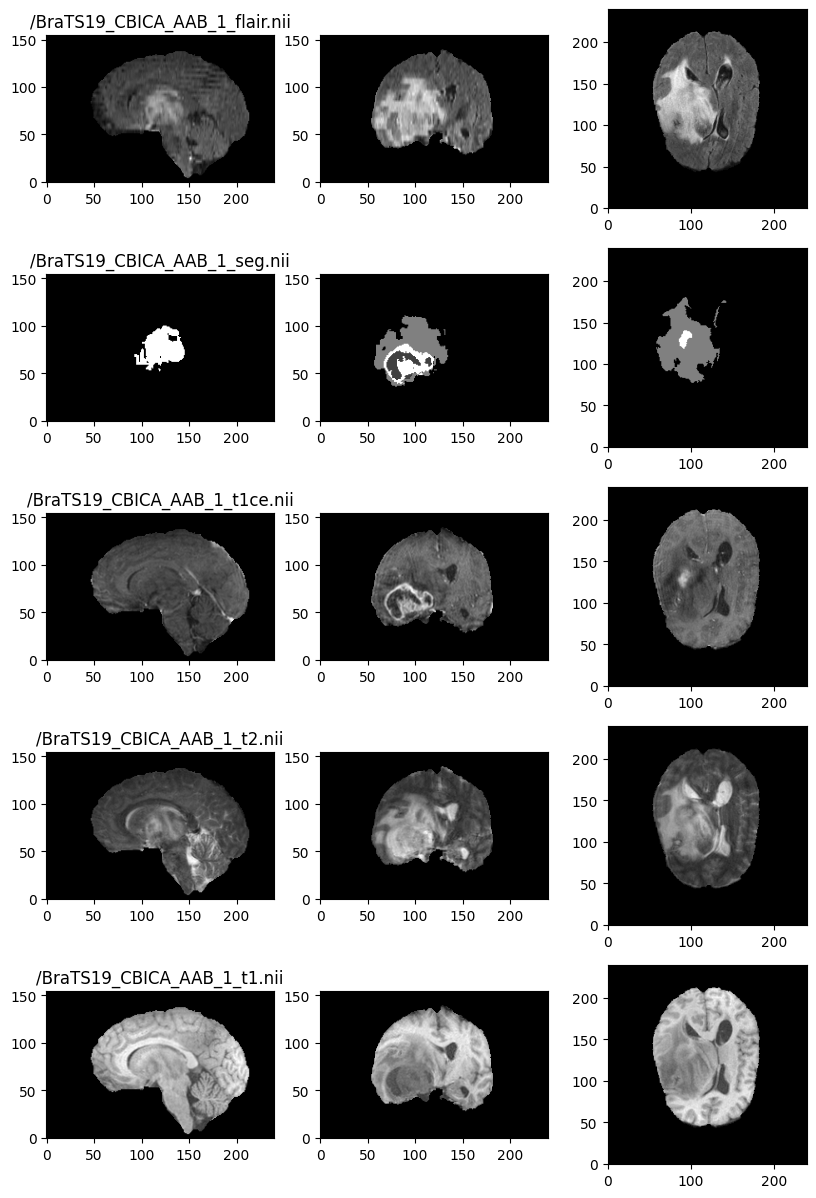

In [4]:
import numpy as np
import nibabel as nib
import matplotlib as mpl
from matplotlib import pyplot as plt
# mpl.rcParams["figure.figsize"] = (10, 10)


ex_dir = data_dirs[0]
dir_files = [os.path.join(ex_dir, item) for item in os.listdir(ex_dir)]
fig, axs = plt.subplots(nrows=len(dir_files), ncols=3, figsize=(10, 15))

for n_row, fname in enumerate(dir_files):
  f_data = nib.load(fname)
  img = f_data.get_fdata(dtype=np.float32)

  axs[n_row, 0].set_title(fname.replace(ex_dir, ""))

  axs[n_row, 0].imshow(img[120, ...].T, cmap="gray", origin="lower")
  axs[n_row, 1].imshow(img[:, 120, :].T, cmap="gray", origin="lower")
  axs[n_row, 2].imshow(img[..., 80].T, cmap="gray", origin="lower")

ex_labels = nib.load([item for item in dir_files if "seg.nii" in item][0])\
            .get_fdata(dtype=np.float32)
print("Tumor labels:", np.unique(ex_labels))

In [5]:
from glob import glob
import tensorflow as tf
import tensorflow.data as tf_data
from keras.utils import to_categorical


def pad_image(data, shape):
    """Calculate the amount of padding to add to an image to obtain a desired
    shape."""
    pad_width = [(0, s - d) if s > d else (0, 0) for d, s
                 in zip(data.shape, shape)]
    return np.pad(data, pad_width, mode='constant')


def read_image(x, dtype):
    data = nib.load(x)
    image = np.array(data.get_fdata())
    return image.astype(dtype)


def read_mask(x, dtype):
    data = nib.load(x)
    mask = np.array(data.get_fdata())
    return mask.astype(dtype)


def preprocess(images, masks):
    def f(x, y):
      # Read all the non-segmentation images from the x argument and pad them.
      x_imgs = []
      for item in x:
        item = read_image(item.decode(), dtype=np.float32)
        item = pad_image(item, (240, 240, 160))
        x_imgs.append(item)

      # Stack and normalize all the padded non-segmentation images into a 4D
      # array considering the 4 channels.
      x = np.stack(x_imgs, axis=-1)
      x /= x.max()

      # Read and pad the segmentation mask from the y argument.
      y = y.decode()
      y = read_mask(y, dtype=np.int32)
      y = pad_image(y, (240, 240, 160))

      # Map and change the labels from [0, 1, 2, 4] as presented in the dataset
      # description to labels [0, 1, 2, 3] to be able to pass it to categorical.
      map_dict = {msk: y_lab for y_lab, msk in enumerate(np.unique(y))}
      vectorized_map = np.vectorize(map_dict.get)
      y = vectorized_map(y)

      # Apply the mapping and change the initial volume with different labels to
      # a 4-D tensor containing as channels the binarized masks of each category
      # of data.
      y = to_categorical(y)

      return x, y

    image, mask = tf.numpy_function(f, [images, masks],
     [tf.float32, tf.float32])
    image.set_shape([240, 240, 160, 4])
    mask.set_shape([240, 240, 160, 4])
    return image, mask

In [7]:
images = [
    [item for item in glob(os.path.join(dir, r"*.nii"))
    if "seg.nii" not in item]
    for dir in data_dirs
    ]
masks = [glob(os.path.join(item, r"*seg.nii"))[0] for item in data_dirs]

dataset = tf_data.Dataset.from_tensor_slices((images, masks))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.map(preprocess).batch(5)
dataset = dataset.prefetch(2)

In [8]:
for image, mask in dataset.take(1):
    # Here we should have a 4-D tensor with shape of (240, 240, 160, 4) due to
    # its four channels.
    print(image.numpy().shape)
    img = image.numpy()[0, ...]
    msk = mask.numpy()[0, ...]

(5, 240, 240, 160, 4)


# Build and train the 3D U-Net model

In [13]:
model = build_unet((240, 240, 160, 4), 4)

softmax


In [14]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 160, 4)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 240, 240, 160, 4)     436       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 240, 240, 160, 4)     0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 240, 240, 160, 4)     436       ['activation[0][0]']          
                                                                                              

In [16]:
batch_size = 5
num_batches = len(images) // batch_size
train_batches = int(np.floor(num_batches * 0.8))
validation_batches = int(np.floor(num_batches * 0.15))

train_ds = dataset.take(train_batches)
validation_ds = dataset.skip(train_batches).take(validation_batches)
test_ds = dataset.skip(train_batches + validation_batches)

print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(validation_ds)} batches")
print(f"Test dataset: {len(test_ds)} batches")

Training dataset: 53 batches
Validation dataset: 10 batches
Test dataset: 4 batches


In [17]:
from keras.optimizers import Adam


model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient]
)

In [ ]:
history = model.fit(train_ds, batch_size=batch_size,
                    epochs=10, validation_data=validation_ds)

Epoch 1/10
 2/53 [>.............................] - ETA: 1:03:23 - loss: 0.7490 - dice_coefficient: 0.2510 